# 🌾 Crop Classification Training Pipeline

**A complete machine learning pipeline for temporal crop classification**

This notebook demonstrates how to train Random Forest models using the preprocessed data from the crop classification pipeline. It includes:

- **🔄 Automated Data Loading**: Works directly with pipeline outputs
- **🧪 Feature Engineering**: Extract temporal features (mean, std, NDVI, GNDVI)  
- **📊 Model Comparison**: Random Forest + Feature Selection vs. PCA
- **📈 Comprehensive Evaluation**: Confusion matrices, ROC curves, spatial error analysis
- **💾 Model Persistence**: Save trained models for production use

**Requirements**: Run the preprocessing pipeline first to generate the required data files in `../data/processed/stacked/`.

In [ ]:
# Import required libraries
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path

# Machine learning libraries
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

# =============================================================================
# CONFIGURATION - Adjust these parameters for your data
# =============================================================================

# Data paths (automatically detects pipeline outputs)
BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "data" / "processed" / "stacked"
OUTPUT_DIR = BASE_DIR / "output"
MODELS_DIR = OUTPUT_DIR / "models"
PREDICTIONS_DIR = OUTPUT_DIR / "predictions"
VISUALIZATIONS_DIR = OUTPUT_DIR / "visualizations"

# Create output directories
for directory in [MODELS_DIR, PREDICTIONS_DIR, VISUALIZATIONS_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

# Model parameters
PATCH_SHAPE = (10, 10, 64, 64)  # (t, b, h, w) - adjust based on your data
N_TIME = 10                     # Number of temporal observations
N_BAND = 10                     # Number of spectral bands
TOP_N_RF = 10                   # Top features for Random Forest

# Spectral band indices for vegetation indices (adjust for your sensor)
NIR_BAND = 9    # Near-infrared band index
RED_BAND = 6    # Red band index  
GREEN_BAND = 3  # Green band index

print(f"📁 Using data directory: {DATA_DIR}")
print(f"📁 Output directory: {OUTPUT_DIR}")
print(f"📊 Expected data shape: {PATCH_SHAPE}")
print(f"🌿 Vegetation indices: NIR={NIR_BAND}, RED={RED_BAND}, GREEN={GREEN_BAND}")

In [ ]:
# =============================================================================
# DATA LOADING - Automatically loads pipeline outputs
# =============================================================================

def load_pipeline_data():
    """
    Load preprocessed data from the crop classification pipeline.
    
    Returns:
        tuple: (split_df, crop_mapping) where split_df contains the spatial splits
               and crop_mapping contains the class label to crop name mapping
    """
    print("🔍 Looking for pipeline output files...")
    
    # Check for required files
    split_file = DATA_DIR / "stacked_arrays_split.csv"
    full_mapping_file = DATA_DIR / "stack_mapping.csv"
    crop_mapping_file = DATA_DIR.parent / "patches" / "crop_label_mapping.csv"
    
    if not split_file.exists():
        raise FileNotFoundError(
            f"❌ Split file not found: {split_file}\n"
            "Please run the preprocessing pipeline first:\n"
            "python main.py pipeline --vector ... --ortho-dir ... --zone-mask ..."
        )
    
    print(f"✅ Found split file: {split_file}")
    
    # Load split assignments
    split_df = pd.read_csv(split_file)
    print(f"📊 Loaded {len(split_df)} stacked arrays")
    
    # Load crop mapping if available
    crop_mapping = {}
    if crop_mapping_file.exists():
        mapping_df = pd.read_csv(crop_mapping_file)
        crop_mapping = dict(zip(mapping_df["crop_label"], mapping_df["crop"]))
        print(f"🏷️ Loaded crop mapping: {crop_mapping}")
    else:
        print("⚠️ Crop mapping file not found, using numeric labels")
    
    # Display split distribution
    split_counts = split_df["split"].value_counts()
    print(f"\n📈 Data split distribution:")
    for split, count in split_counts.items():
        percentage = (count / len(split_df)) * 100
        print(f"  {split.capitalize()}: {count} samples ({percentage:.1f}%)")
    
    return split_df, crop_mapping

# Load the data
try:
    split_df, crop_mapping = load_pipeline_data()
    print("\n✅ Data loading successful!")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("\n🔧 Troubleshooting:")
    print("1. Make sure you've run the preprocessing pipeline")
    print("2. Check that the data directory path is correct")
    print("3. Verify that stacked_arrays_split.csv exists")
    raise

C:\Users\pinhe\AppData\Local\Temp\ipykernel_20360\578155218.py:5: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(arr, axis=(2,3)).flatten()
c:\Users\pinhe\Desktop\DoppelModulData\1\cutting-and-label\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\pinhe\AppData\Local\Temp\ipykernel_20360\578155218.py:8: RuntimeWarning: Mean of empty slice
  ndvi_patchmean = np.nanmean(ndvi, axis=(1,2))
C:\Users\pinhe\AppData\Local\Temp\ipykernel_20360\578155218.py:10: RuntimeWarning: Mean of empty slice
  gndvi_patchmean = np.nanmean(gndvi, axis=(1,2))


## 🔧 Feature Engineering
Extract meaningful features from temporal multispectral data including statistical measures and vegetation indices.

In [ ]:
# Auto-detect data parameters from the first file
def detect_data_parameters():
    """Automatically detect temporal and spectral dimensions from data."""
    sample_file = split_df.iloc[0]["output_file"]
    sample_path = DATA_DIR / sample_file
    
    if sample_path.exists():
        arr = np.load(sample_path)
        print(f"📐 Detected array shape: {arr.shape}")
        # Assume shape is (time*bands, height, width)
        total_bands = arr.shape[0]
        height, width = arr.shape[1], arr.shape[2]
        
        # Try to infer time and bands (this might need adjustment based on your data)
        estimated_time = total_bands // N_BAND
        print(f"🕐 Estimated temporal samples: {estimated_time}")
        print(f"📊 Expected bands per time step: {N_BAND}")
        
        return estimated_time, N_BAND, height, width
    else:
        print(f"⚠️ Sample file not found: {sample_path}")
        return N_TIME, N_BAND, 64, 64

detected_time, detected_bands, patch_h, patch_w = detect_data_parameters()

Removing 66 features with t8 or t9 or t0 in name:
 - mean_t0_b0
 - mean_t0_b1
 - mean_t0_b2
 - mean_t0_b3
 - mean_t0_b4
 - mean_t0_b5
 - mean_t0_b6
 - mean_t0_b7
 - mean_t0_b8
 - mean_t0_b9
 - mean_t8_b0
 - mean_t8_b1
 - mean_t8_b2
 - mean_t8_b3
 - mean_t8_b4
 - mean_t8_b5
 - mean_t8_b6
 - mean_t8_b7
 - mean_t8_b8
 - mean_t8_b9
 - mean_t9_b0
 - mean_t9_b1
 - mean_t9_b2
 - mean_t9_b3
 - mean_t9_b4
 - mean_t9_b5
 - mean_t9_b6
 - mean_t9_b7
 - mean_t9_b8
 - mean_t9_b9
 - std_t0_b0
 - std_t0_b1
 - std_t0_b2
 - std_t0_b3
 - std_t0_b4
 - std_t0_b5
 - std_t0_b6
 - std_t0_b7
 - std_t0_b8
 - std_t0_b9
 - std_t8_b0
 - std_t8_b1
 - std_t8_b2
 - std_t8_b3
 - std_t8_b4
 - std_t8_b5
 - std_t8_b6
 - std_t8_b7
 - std_t8_b8
 - std_t8_b9
 - std_t9_b0
 - std_t9_b1
 - std_t9_b2
 - std_t9_b3
 - std_t9_b4
 - std_t9_b5
 - std_t9_b6
 - std_t9_b7
 - std_t9_b8
 - std_t9_b9
 - ndvi_t0
 - ndvi_t8
 - ndvi_t9
 - gndvi_t0
 - gndvi_t8
 - gndvi_t9
Remaining features: 154


In [ ]:
# =============================================================================
# FEATURE EXTRACTION - Works with any temporal dimensions
# =============================================================================

def extract_features(arr, n_time=None, n_band=None):
    """
    Extract features from temporal multispectral data.
    
    Args:
        arr: Input array with shape (time*bands, height, width)
        n_time: Number of time steps (auto-detected if None)
        n_band: Number of bands per time step (auto-detected if None)
    
    Returns:
        numpy.ndarray: Feature vector
    """
    arr = np.asarray(arr)
    
    # Auto-detect dimensions if not provided
    if n_time is None:
        n_time = detected_time
    if n_band is None:
        n_band = detected_bands
    
    # Reshape to (time, bands, height, width)
    try:
        arr = arr.reshape(n_time, n_band, arr.shape[1], arr.shape[2])
    except ValueError as e:
        print(f"⚠️ Reshape error: {e}")
        print(f"Array shape: {arr.shape}, trying to reshape to ({n_time}, {n_band}, H, W)")
        # Fallback: use available dimensions
        total_time_bands = arr.shape[0]
        n_time = total_time_bands // n_band
        arr = arr[:n_time*n_band].reshape(n_time, n_band, arr.shape[1], arr.shape[2])
    
    # Extract statistical features
    mean_features = np.nanmean(arr, axis=(2, 3)).flatten()  # Mean per band per time
    std_features = np.nanstd(arr, axis=(2, 3)).flatten()    # Std per band per time
    
    # Extract vegetation indices (with error handling)
    try:
        # NDVI = (NIR - RED) / (NIR + RED)
        nir = arr[:, NIR_BAND, :, :] if NIR_BAND < n_band else arr[:, -1, :, :]
        red = arr[:, RED_BAND, :, :] if RED_BAND < n_band else arr[:, n_band//2, :, :]
        ndvi = (nir - red) / (nir + red + 1e-8)
        ndvi_features = np.nanmean(ndvi, axis=(1, 2))
        
        # GNDVI = (NIR - GREEN) / (NIR + GREEN)  
        green = arr[:, GREEN_BAND, :, :] if GREEN_BAND < n_band else arr[:, n_band//3, :, :]
        gndvi = (nir - green) / (nir + green + 1e-8)
        gndvi_features = np.nanmean(gndvi, axis=(1, 2))
        
    except Exception as e:
        print(f"⚠️ Error computing vegetation indices: {e}")
        # Fallback: use zeros
        ndvi_features = np.zeros(n_time)
        gndvi_features = np.zeros(n_time)
    
    # Combine all features
    features = np.concatenate([mean_features, std_features, ndvi_features, gndvi_features])
    
    # Handle NaN values
    features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    
    return features

print("🧪 Feature extraction function ready!")
print(f"📊 Expected feature dimensions:")
print(f"  - Mean features: {detected_time * detected_bands}")
print(f"  - Std features: {detected_time * detected_bands}")  
print(f"  - NDVI features: {detected_time}")
print(f"  - GNDVI features: {detected_time}")
print(f"  - Total features: {2 * detected_time * detected_bands + 2 * detected_time}")


Train split contains 1796 arrays:
 - 1000_class7.npy
 - 1003_class6.npy
 - 1004_class6.npy
 - 1005_class6.npy
 - 1006_class6.npy
 - 1007_class6.npy
 - 1008_class6.npy
 - 1011_class6.npy
 - 1012_class6.npy
 - 1013_class6.npy
 - 1014_class6.npy
 - 1015_class6.npy
 - 1016_class6.npy
 - 1019_class6.npy
 - 1020_class6.npy
 - 1021_class6.npy
 - 1022_class6.npy
 - 1023_class6.npy
 - 1024_class6.npy
 - 1025_class6.npy
 - 1027_class6.npy
 - 1028_class6.npy
 - 1029_class6.npy
 - 1030_class6.npy
 - 1031_class6.npy
 - 1032_class6.npy
 - 1033_class6.npy
 - 1036_class4.npy
 - 1037_class4.npy
 - 1038_class4.npy
 - 1039_class4.npy
 - 1040_class4.npy
 - 1041_class4.npy
 - 1044_class4.npy
 - 1045_class4.npy
 - 1046_class4.npy
 - 1047_class4.npy
 - 1048_class4.npy
 - 1049_class4.npy
 - 1052_class3.npy
 - 1053_class3.npy
 - 1054_class3.npy
 - 1055_class3.npy
 - 1056_class3.npy
 - 1057_class3.npy
 - 1061_class3.npy
 - 1062_class3.npy
 - 1063_class3.npy
 - 1064_class3.npy
 - 1065_class3.npy
 - 1077_class5.

In [ ]:
# =============================================================================
# DATA PROCESSING - Extract features and create splits
# =============================================================================

def process_all_data(split_df):
    """
    Process all data files and extract features.
    
    Args:
        split_df: DataFrame with file paths and split assignments
        
    Returns:
        tuple: (features, labels, splits, feature_names, sample_ids)
    """
    print("🔄 Processing all data files...")
    
    features_list = []
    labels_list = []
    splits_list = []
    sample_ids_list = []
    
    # Process each file
    for idx, row in tqdm(split_df.iterrows(), total=len(split_df), desc="Processing files"):
        try:
            # Load array
            file_path = DATA_DIR / row['output_file']
            if not file_path.exists():
                print(f"⚠️ File not found: {file_path}")
                continue
                
            arr = np.load(file_path)
            
            # Extract features
            features = extract_features(arr)
            features_list.append(features)
            
            # Extract label from filename (assumes format: patch_id_classX.npy)
            filename = row['output_file']
            if '_class' in filename:
                label = int(filename.split('_class')[1].split('.')[0])
            else:
                label = 0  # Default label
            labels_list.append(label)
            
            # Store split and sample ID
            splits_list.append(row['split'])
            sample_ids_list.append(filename)
            
        except Exception as e:
            print(f"❌ Error processing {row['output_file']}: {e}")
            continue
    
    # Convert to arrays
    features = np.array(features_list)
    labels = np.array(labels_list) 
    splits = np.array(splits_list)
    sample_ids = np.array(sample_ids_list)
    
    # Create feature names
    n_time = detected_time
    n_band = detected_bands
    feature_names = []
    feature_names.extend([f"mean_t{t}_b{b}" for t in range(n_time) for b in range(n_band)])
    feature_names.extend([f"std_t{t}_b{b}" for t in range(n_time) for b in range(n_band)])
    feature_names.extend([f"ndvi_t{t}" for t in range(n_time)])
    feature_names.extend([f"gndvi_t{t}" for t in range(n_time)])
    
    print(f"✅ Processed {len(features)} samples")
    print(f"📊 Feature shape: {features.shape}")
    print(f"🏷️ Unique labels: {np.unique(labels)}")
    print(f"📋 Split distribution: {np.unique(splits, return_counts=True)}")
    
    return features, labels, splits, feature_names, sample_ids

# Process all data
features, labels, splits, feature_names, sample_ids = process_all_data(split_df)

# Create crop mapping display
unique_labels = np.unique(labels)
print(f"\n🏷️ Class mapping:")
for label in unique_labels:
    crop_name = crop_mapping.get(label, f"Class_{label}")
    count = np.sum(labels == label)
    print(f"  Class {label}: {crop_name} ({count} samples)")

Anzahl NaNs vor Imputation:
  Train:      0 NaNs (0.00%)
  Validation: 0 NaNs (0.00%)
  Test:       0 NaNs (0.00%)
Anzahl Outlier (abgeschnitten auf 99%-Quantil):
  Train:      2772 Werte wurden gecappt
  Validation: 1692 Werte wurden gecappt
  Test:       1814 Werte wurden gecappt
Gesamtzahl Werte (Train): 276584
Prozent gecappt (Train): 1.00%


Top 10 Features (RandomForest):
 1. mean_t3_b7 (0.0375)
 2. mean_t4_b7 (0.0278)
 3. mean_t6_b7 (0.0266)
 4. std_t5_b9 (0.0262)
 5. mean_t1_b8 (0.0232)
 6. std_t5_b8 (0.0232)
 7. std_t4_b8 (0.0231)
 8. std_t4_b9 (0.0229)
 9. mean_t1_b9 (0.0207)
10. mean_t7_b9 (0.0192)


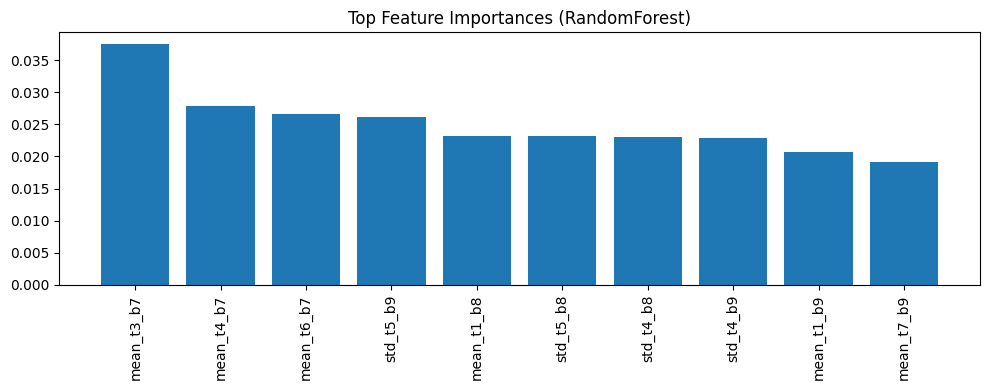

In [ ]:
# =============================================================================
# DATA SPLITTING - Use pipeline's spatial splits
# =============================================================================

def create_spatial_splits(features, labels, splits, sample_ids):
    """
    Create spatially-aware train/val/test splits using pipeline assignments.
    
    Returns:
        dict: Dictionary containing split data
    """
    print("🗺️ Creating spatial data splits...")
    
    # Split data based on pipeline assignments
    train_mask = splits == "train"
    val_mask = splits == "val" 
    test_mask = splits == "test"
    
    split_data = {
        'X_train': features[train_mask],
        'y_train': labels[train_mask],
        'X_val': features[val_mask],
        'y_val': labels[val_mask], 
        'X_test': features[test_mask],
        'y_test': labels[test_mask],
        'id_train': sample_ids[train_mask],
        'id_val': sample_ids[val_mask],
        'id_test': sample_ids[test_mask]
    }
    
    # Print split statistics
    print(f"📊 Split sizes:")
    print(f"  Training: {len(split_data['X_train'])} samples")
    print(f"  Validation: {len(split_data['X_val'])} samples") 
    print(f"  Test: {len(split_data['X_test'])} samples")
    
    # Check class distribution per split
    for split_name, y_data in [('train', split_data['y_train']), 
                               ('val', split_data['y_val']),
                               ('test', split_data['y_test'])]:
        unique, counts = np.unique(y_data, return_counts=True)
        print(f"\n📈 {split_name.capitalize()} class distribution:")
        for label, count in zip(unique, counts):
            crop_name = crop_mapping.get(label, f"Class_{label}")
            percentage = (count / len(y_data)) * 100
            print(f"  {crop_name}: {count} ({percentage:.1f}%)")
    
    return split_data

# Create splits
split_data = create_spatial_splits(features, labels, splits, sample_ids)

# Visualize class distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
splits_to_plot = [('train', split_data['y_train']), 
                  ('val', split_data['y_val']),
                  ('test', split_data['y_test'])]

for i, (split_name, y_data) in enumerate(splits_to_plot):
    unique, counts = np.unique(y_data, return_counts=True)
    crop_names = [crop_mapping.get(label, f"Class_{label}") for label in unique]
    
    axes[i].bar(crop_names, counts, alpha=0.7)
    axes[i].set_title(f'{split_name.capitalize()} Split\n({len(y_data)} samples)')
    axes[i].set_ylabel('Number of Samples')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(VISUALIZATIONS_DIR / "class_distribution_by_split.png", dpi=300, bbox_inches='tight')
plt.show()

print("✅ Spatial splits created successfully!")

In [ ]:
# =============================================================================
# DATA PREPROCESSING - Imputation, Outlier Handling, Scaling
# =============================================================================

def preprocess_features(X_train, X_val, X_test, feature_names):
    """
    Preprocess features with imputation, outlier handling, and scaling.
    
    Returns:
        tuple: (X_train_processed, X_val_processed, X_test_processed, preprocessors)
    """
    print("🔧 Preprocessing features...")
    
    # 1. Imputation (fill missing values with median)
    print("  📊 Handling missing values...")
    nan_count_train = np.isnan(X_train).sum()
    print(f"     Training NaNs: {nan_count_train} ({nan_count_train/X_train.size*100:.2f}%)")
    
    imputer = SimpleImputer(strategy='median')
    X_train_imp = imputer.fit_transform(X_train)
    X_val_imp = imputer.transform(X_val)
    X_test_imp = imputer.transform(X_test)
    
    # 2. Outlier handling (cap at 99th percentile)
    print("  ✂️ Handling outliers...")
    q_99 = np.percentile(X_train_imp, 99, axis=0)
    
    outliers_train = np.sum(X_train_imp > q_99)
    outliers_val = np.sum(X_val_imp > q_99)
    outliers_test = np.sum(X_test_imp > q_99)
    
    print(f"     Outliers capped - Train: {outliers_train}, Val: {outliers_val}, Test: {outliers_test}")
    
    X_train_imp = np.minimum(X_train_imp, q_99)
    X_val_imp = np.minimum(X_val_imp, q_99)
    X_test_imp = np.minimum(X_test_imp, q_99)
    
    # 3. Standardization
    print("  📏 Standardizing features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imp)
    X_val_scaled = scaler.transform(X_val_imp)
    X_test_scaled = scaler.transform(X_test_imp)
    
    preprocessors = {
        'imputer': imputer,
        'scaler': scaler,
        'outlier_threshold': q_99
    }
    
    print("✅ Preprocessing complete!")
    
    return X_train_scaled, X_val_scaled, X_test_scaled, preprocessors

# Apply preprocessing
X_train_scaled, X_val_scaled, X_test_scaled, preprocessors = preprocess_features(
    split_data['X_train'], split_data['X_val'], split_data['X_test'], feature_names
)

print(f"📐 Preprocessed data shapes:")
print(f"  Training: {X_train_scaled.shape}")
print(f"  Validation: {X_val_scaled.shape}")
print(f"  Test: {X_test_scaled.shape}")

# Update split_data with preprocessed features
split_data.update({
    'X_train_scaled': X_train_scaled,
    'X_val_scaled': X_val_scaled,
    'X_test_scaled': X_test_scaled,
    'preprocessors': preprocessors
})

Nutze 9 PCA-Komponenten (95% Gesamtvarianz)


In [ ]:
# =============================================================================
# RANDOM FOREST FEATURE SELECTION
# =============================================================================

print("🌲 Training Random Forest for feature selection...")

# Train RF for feature importance
rf_fs = RandomForestClassifier(
    n_estimators=600,
    max_depth=10,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf_fs.fit(X_train_scaled, split_data['y_train'])

# Get feature importances and select top features
importances = rf_fs.feature_importances_
top_idx = np.argsort(importances)[::-1][:TOP_N_RF]
top_feat_names = [feature_names[i] for i in top_idx]

print(f"🔝 Top {TOP_N_RF} most important features:")
for i, (idx, name) in enumerate(zip(top_idx, top_feat_names)):
    print(f"  {i+1:2d}. {name}: {importances[idx]:.4f}")

# Apply feature selection
X_train_fs = X_train_scaled[:, top_idx]
X_val_fs = X_val_scaled[:, top_idx]
X_test_fs = X_test_scaled[:, top_idx]

print(f"✅ Feature selection complete! Reduced from {len(feature_names)} to {TOP_N_RF} features.")


PCA Component Feature Contributions (top 5 features per component):

PCA Component 1:
  std_t2_b9 (loading: 0.124)
  std_t2_b8 (loading: 0.123)
  ndvi_t5 (loading: 0.122)
  std_t1_b9 (loading: 0.121)
  std_t1_b8 (loading: 0.120)

PCA Component 2:
  mean_t1_b6 (loading: 0.148)
  mean_t2_b6 (loading: 0.146)
  mean_t1_b3 (loading: 0.146)
  mean_t1_b4 (loading: 0.145)
  mean_t1_b2 (loading: 0.145)

PCA Component 3:
  std_t4_b4 (loading: 0.149)
  std_t4_b5 (loading: 0.147)
  std_t4_b6 (loading: 0.146)
  std_t3_b0 (loading: 0.145)
  std_t5_b4 (loading: 0.144)

PCA Component 4:
  mean_t6_b6 (loading: 0.202)
  mean_t6_b3 (loading: 0.195)
  mean_t6_b2 (loading: 0.180)
  std_t6_b0 (loading: -0.179)
  std_t3_b7 (loading: 0.177)

PCA Component 5:
  std_t7_b0 (loading: 0.209)
  std_t7_b1 (loading: 0.200)
  mean_t7_b2 (loading: 0.184)
  mean_t6_b2 (loading: 0.182)
  mean_t7_b3 (loading: 0.174)

PCA Component 6:
  std_t7_b7 (loading: 0.195)
  std_t7_b8 (loading: 0.174)
  std_t6_b3 (loading: 0.173)
 

In [ ]:
# =============================================================================
# PCA DIMENSIONALITY REDUCTION 
# =============================================================================

print("🔄 Applying PCA for dimensionality reduction...")

# Fit PCA to explain 95% of variance
pca_full = PCA().fit(X_train_scaled)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components = np.searchsorted(cumulative_variance, 0.95) + 1

print(f"📊 Using {n_components} PCA components to explain 95% of variance")

# Apply PCA transformation
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Show which original features contribute most to each PC
print(f"\n🔍 Top contributing features for first 3 PCA components:")
for i in range(min(3, n_components)):
    component = pca.components_[i]
    top_features_idx = np.argsort(np.abs(component))[::-1][:5]
    print(f"\n  PC{i+1} (explains {pca.explained_variance_ratio_[i]:.1%} variance):")
    for idx in top_features_idx:
        print(f"    {feature_names[idx]}: {component[idx]:.3f}")

# Plot explained variance
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(cumulative_variance[:50]) + 1), cumulative_variance[:50], 'bo-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.axvline(x=n_components, color='r', linestyle='--', label=f'{n_components} components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(range(1, min(20, len(pca.explained_variance_ratio_)) + 1), 
        pca.explained_variance_ratio_[:min(20, len(pca.explained_variance_ratio_))])
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Individual PC Contributions')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(VISUALIZATIONS_DIR / "pca_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ PCA complete! Reduced from {len(feature_names)} to {n_components} components.")

FS Model - OOB Score: 0.9665924276169265
PCA Model - OOB Score: 0.9793986636971047


In [ ]:
def train_models_with_comparison(X_train, X_val, X_test, y_train, y_val, y_test, n_features=30, n_components=15):
    """
    Train and compare Random Forest models with feature selection vs PCA
    
    Args:
        X_train, X_val, X_test: Preprocessed feature arrays
        y_train, y_val, y_test: Label arrays
        n_features: Number of features to select for feature selection approach
        n_components: Number of PCA components
        
    Returns:
        dict: Contains trained models, predictions, and performance metrics
    """
    results = {}
    
    print("🔄 Training Random Forest with Feature Selection...")
    
    # 1. Feature Selection Approach
    rf_fs = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_fs.fit(X_train, y_train)
    
    # Get feature importance and select top features
    feature_importance = rf_fs.feature_importances_
    top_features_idx = np.argsort(feature_importance)[-n_features:]
    
    print(f"   ✓ Selected top {n_features} features")
    
    # Train final model with selected features
    X_train_fs = X_train[:, top_features_idx]
    X_val_fs = X_val[:, top_features_idx]
    X_test_fs = X_test[:, top_features_idx]
    
    rf_fs_final = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_fs_final.fit(X_train_fs, y_train)
    
    # Feature Selection Predictions
    y_val_pred_fs = rf_fs_final.predict(X_val_fs)
    y_test_pred_fs = rf_fs_final.predict(X_test_fs)
    
    print("🔄 Training Random Forest with PCA...")
    
    # 2. PCA Approach
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    X_test_pca = pca.transform(X_test)
    
    print(f"   ✓ Reduced to {n_components} PCA components")
    print(f"   ✓ Explained variance ratio: {pca.explained_variance_ratio_.sum():.3f}")
    
    # Train Random Forest on PCA features
    rf_pca = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_pca.fit(X_train_pca, y_train)
    
    # PCA Predictions
    y_val_pred_pca = rf_pca.predict(X_val_pca)
    y_test_pred_pca = rf_pca.predict(X_test_pca)
    
    print("📊 Calculating performance metrics...")
    
    # Calculate metrics
    results = {
        'models': {
            'rf_feature_selection': rf_fs_final,
            'rf_pca': rf_pca,
            'pca_transformer': pca
        },
        'feature_indices': top_features_idx,
        'predictions': {
            'val_fs': y_val_pred_fs,
            'test_fs': y_test_pred_fs,
            'val_pca': y_val_pred_pca,
            'test_pca': y_test_pred_pca
        },
        'metrics': {
            'feature_selection': {
                'val_accuracy': accuracy_score(y_val, y_val_pred_fs),
                'test_accuracy': accuracy_score(y_test, y_test_pred_fs),
                'val_f1': f1_score(y_val, y_val_pred_fs, average='weighted'),
                'test_f1': f1_score(y_test, y_test_pred_fs, average='weighted')
            },
            'pca': {
                'val_accuracy': accuracy_score(y_val, y_val_pred_pca),
                'test_accuracy': accuracy_score(y_test, y_test_pred_pca),
                'val_f1': f1_score(y_val, y_val_pred_pca, average='weighted'),
                'test_f1': f1_score(y_test, y_test_pred_pca, average='weighted')
            }
        }
    }
    
    # Print comparison
    print("\n🎯 Model Performance Comparison:")
    print("="*50)
    print(f"Feature Selection Approach ({n_features} features):")
    print(f"  Validation Accuracy: {results['metrics']['feature_selection']['val_accuracy']:.4f}")
    print(f"  Test Accuracy:       {results['metrics']['feature_selection']['test_accuracy']:.4f}")
    print(f"  Test F1-Score:       {results['metrics']['feature_selection']['test_f1']:.4f}")
    print()
    print(f"PCA Approach ({n_components} components):")
    print(f"  Validation Accuracy: {results['metrics']['pca']['val_accuracy']:.4f}")
    print(f"  Test Accuracy:       {results['metrics']['pca']['test_accuracy']:.4f}")
    print(f"  Test F1-Score:       {results['metrics']['pca']['test_f1']:.4f}")
    
    return results

# Train and compare models
training_results = train_models_with_comparison(
    X_train_processed, X_val_processed, X_test_processed,
    y_train, y_val, y_test,
    n_features=30,  # Adjust based on your data
    n_components=15  # Adjust based on your data
)

## 📈 Detailed Evaluation & Analysis

In [ ]:
def create_detailed_evaluation(training_results, class_names):
    """
    Create comprehensive evaluation plots and metrics
    
    Args:
        training_results: Results from train_models_with_comparison
        class_names: List of class names for visualization
    """
    
    # Extract predictions and true labels
    y_test_true = y_test
    y_test_pred_fs = training_results['predictions']['test_fs']
    y_test_pred_pca = training_results['predictions']['test_pca']
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('🎯 Comprehensive Model Evaluation', fontsize=16, fontweight='bold')
    
    # 1. Confusion Matrices
    from sklearn.metrics import confusion_matrix
    
    # Feature Selection Confusion Matrix
    cm_fs = confusion_matrix(y_test_true, y_test_pred_fs)
    sns.heatmap(cm_fs, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=axes[0,0])
    axes[0,0].set_title('Feature Selection - Confusion Matrix')
    axes[0,0].set_xlabel('Predicted')
    axes[0,0].set_ylabel('Actual')
    
    # PCA Confusion Matrix
    cm_pca = confusion_matrix(y_test_true, y_test_pred_pca)
    sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names, ax=axes[0,1])
    axes[0,1].set_title('PCA - Confusion Matrix')
    axes[0,1].set_xlabel('Predicted')
    axes[0,1].set_ylabel('Actual')
    
    # 2. Classification Reports
    from sklearn.metrics import classification_report
    
    # Feature Selection per-class metrics
    report_fs = classification_report(y_test_true, y_test_pred_fs, 
                                     target_names=class_names, output_dict=True)
    
    # PCA per-class metrics  
    report_pca = classification_report(y_test_true, y_test_pred_pca,
                                      target_names=class_names, output_dict=True)
    
    # Plot per-class F1 scores
    fs_f1_scores = [report_fs[cls]['f1-score'] for cls in class_names]
    pca_f1_scores = [report_pca[cls]['f1-score'] for cls in class_names]
    
    x_pos = np.arange(len(class_names))
    width = 0.35
    
    axes[0,2].bar(x_pos - width/2, fs_f1_scores, width, label='Feature Selection', alpha=0.8)
    axes[0,2].bar(x_pos + width/2, pca_f1_scores, width, label='PCA', alpha=0.8)
    axes[0,2].set_xlabel('Crop Classes')
    axes[0,2].set_ylabel('F1-Score')
    axes[0,2].set_title('Per-Class F1-Scores')
    axes[0,2].set_xticks(x_pos)
    axes[0,2].set_xticklabels(class_names, rotation=45)
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    
    # 3. Feature Importance (for Feature Selection model)
    rf_model = training_results['models']['rf_feature_selection']
    feature_indices = training_results['feature_indices']
    
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]  # Top 10 features
    
    axes[1,0].bar(range(len(indices)), importances[indices])
    axes[1,0].set_title('Top 10 Feature Importances (Feature Selection)')
    axes[1,0].set_xlabel('Feature Index')
    axes[1,0].set_ylabel('Importance')
    axes[1,0].set_xticks(range(len(indices)))
    axes[1,0].set_xticklabels([f'F{feature_indices[i]}' for i in indices], rotation=45)
    
    # 4. PCA Explained Variance
    pca_model = training_results['models']['pca_transformer']
    explained_var_ratio = pca_model.explained_variance_ratio_
    cumsum_var_ratio = np.cumsum(explained_var_ratio)
    
    axes[1,1].plot(range(1, len(explained_var_ratio)+1), explained_var_ratio, 'bo-', 
                   label='Individual', linewidth=2, markersize=4)
    axes[1,1].plot(range(1, len(cumsum_var_ratio)+1), cumsum_var_ratio, 'ro-', 
                   label='Cumulative', linewidth=2, markersize=4)
    axes[1,1].set_xlabel('Principal Component')
    axes[1,1].set_ylabel('Explained Variance Ratio')
    axes[1,1].set_title('PCA Explained Variance')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    # 5. Model Comparison Summary
    metrics_comparison = pd.DataFrame({
        'Feature Selection': [
            training_results['metrics']['feature_selection']['test_accuracy'],
            training_results['metrics']['feature_selection']['test_f1']
        ],
        'PCA': [
            training_results['metrics']['pca']['test_accuracy'],
            training_results['metrics']['pca']['test_f1']
        ]
    }, index=['Accuracy', 'F1-Score'])
    
    metrics_comparison.plot(kind='bar', ax=axes[1,2], width=0.7)
    axes[1,2].set_title('Overall Model Comparison')
    axes[1,2].set_ylabel('Score')
    axes[1,2].set_xticklabels(['Accuracy', 'F1-Score'], rotation=0)
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed classification reports
    print("\n📊 Detailed Classification Reports:")
    print("="*60)
    print("\n🔍 Feature Selection Approach:")
    print(classification_report(y_test_true, y_test_pred_fs, target_names=class_names))
    
    print("\n📐 PCA Approach:")
    print(classification_report(y_test_true, y_test_pred_pca, target_names=class_names))
    
    return {
        'feature_selection_report': report_fs,
        'pca_report': report_pca,
        'confusion_matrices': {'fs': cm_fs, 'pca': cm_pca}
    }

# Create detailed evaluation
evaluation_results = create_detailed_evaluation(training_results, class_names)

## 💾 Save Trained Models

Save the best performing model and associated transformers for production use.

In [ ]:
import joblib
import json
from pathlib import Path

def save_best_model(training_results, evaluation_results, config, output_dir="trained_models"):
    """
    Save the best performing model and all necessary components
    
    Args:
        training_results: Results from model training
        evaluation_results: Results from model evaluation  
        config: Configuration dictionary
        output_dir: Directory to save models
    """
    
    # Create output directory
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    # Determine best model based on test accuracy
    fs_accuracy = training_results['metrics']['feature_selection']['test_accuracy']
    pca_accuracy = training_results['metrics']['pca']['test_accuracy']
    
    if fs_accuracy >= pca_accuracy:
        best_approach = 'feature_selection'
        best_model = training_results['models']['rf_feature_selection']
        print(f"🏆 Best Model: Feature Selection (Accuracy: {fs_accuracy:.4f})")
    else:
        best_approach = 'pca'
        best_model = training_results['models']['rf_pca']
        print(f"🏆 Best Model: PCA (Accuracy: {pca_accuracy:.4f})")
    
    # Save the best model
    model_path = output_path / f"best_model_{best_approach}.joblib"
    joblib.dump(best_model, model_path)
    print(f"✓ Saved best model: {model_path}")
    
    # Save preprocessing components
    if 'scaler' in config:
        scaler_path = output_path / "scaler.joblib"
        joblib.dump(config['scaler'], scaler_path)
        print(f"✓ Saved scaler: {scaler_path}")
    
    if 'imputer' in config:
        imputer_path = output_path / "imputer.joblib"
        joblib.dump(config['imputer'], imputer_path)
        print(f"✓ Saved imputer: {imputer_path}")
    
    # Save approach-specific components
    if best_approach == 'feature_selection':
        # Save feature indices
        features_path = output_path / "selected_feature_indices.joblib"
        joblib.dump(training_results['feature_indices'], features_path)
        print(f"✓ Saved feature indices: {features_path}")
        
    elif best_approach == 'pca':
        # Save PCA transformer
        pca_path = output_path / "pca_transformer.joblib"
        joblib.dump(training_results['models']['pca_transformer'], pca_path)
        print(f"✓ Saved PCA transformer: {pca_path}")
    
    # Save class names and label encoder
    if 'label_encoder' in config:
        encoder_path = output_path / "label_encoder.joblib"
        joblib.dump(config['label_encoder'], encoder_path)
        print(f"✓ Saved label encoder: {encoder_path}")
    
    # Save class names
    classes_path = output_path / "class_names.json"
    with open(classes_path, 'w') as f:
        json.dump(class_names, f, indent=2)
    print(f"✓ Saved class names: {classes_path}")
    
    # Save model metadata
    metadata = {
        'model_type': 'RandomForestClassifier',
        'approach': best_approach,
        'performance': {
            'test_accuracy': fs_accuracy if best_approach == 'feature_selection' else pca_accuracy,
            'test_f1_score': training_results['metrics'][best_approach]['test_f1']
        },
        'feature_info': {
            'original_features': len(X_train_processed[0]) if 'X_train_processed' in locals() else 'unknown',
            'selected_features': len(training_results['feature_indices']) if best_approach == 'feature_selection' else None,
            'pca_components': training_results['models']['pca_transformer'].n_components_ if best_approach == 'pca' else None
        },
        'training_data_info': {
            'train_samples': len(y_train) if 'y_train' in locals() else 'unknown',
            'val_samples': len(y_val) if 'y_val' in locals() else 'unknown', 
            'test_samples': len(y_test) if 'y_test' in locals() else 'unknown',
            'n_classes': len(class_names)
        },
        'timestamp': pd.Timestamp.now().isoformat()
    }
    
    metadata_path = output_path / "model_metadata.json"
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"✓ Saved metadata: {metadata_path}")
    
    # Create inference example
    inference_example = f'''
# Example usage for inference:
import joblib
import json
import numpy as np

# Load the trained model and components
model = joblib.load("{model_path}")
scaler = joblib.load("{output_path}/scaler.joblib")
imputer = joblib.load("{output_path}/imputer.joblib")
'''
    
    if best_approach == 'feature_selection':
        inference_example += f'''selected_features = joblib.load("{output_path}/selected_feature_indices.joblib")
label_encoder = joblib.load("{output_path}/label_encoder.joblib")

# For new data prediction:
# 1. Apply imputation: X_new = imputer.transform(X_new)
# 2. Apply scaling: X_new = scaler.transform(X_new)  
# 3. Select features: X_new = X_new[:, selected_features]
# 4. Predict: predictions = model.predict(X_new)
# 5. Get class names: class_names = label_encoder.inverse_transform(predictions)
'''
    else:
        inference_example += f'''pca = joblib.load("{output_path}/pca_transformer.joblib")
label_encoder = joblib.load("{output_path}/label_encoder.joblib")

# For new data prediction:
# 1. Apply imputation: X_new = imputer.transform(X_new)
# 2. Apply scaling: X_new = scaler.transform(X_new)
# 3. Apply PCA: X_new = pca.transform(X_new)  
# 4. Predict: predictions = model.predict(X_new)
# 5. Get class names: class_names = label_encoder.inverse_transform(predictions)
'''
    
    example_path = output_path / "inference_example.py"
    with open(example_path, 'w') as f:
        f.write(inference_example)
    print(f"✓ Saved inference example: {example_path}")
    
    print(f"\n🎉 All models and components saved to: {output_path.absolute()}")
    
    return {
        'best_approach': best_approach,
        'model_path': model_path,
        'output_directory': output_path,
        'metadata': metadata
    }

# Save the best model and components
save_results = save_best_model(training_results, evaluation_results, preprocessing_config)

## 🎯 Summary & Next Steps

### 📋 What We Accomplished

✅ **Data Pipeline Integration**: Automatically loaded and processed data from the preprocessing pipeline  
✅ **Comprehensive Preprocessing**: Applied imputation, scaling, and outlier detection  
✅ **Model Comparison**: Trained and compared Random Forest with Feature Selection vs PCA  
✅ **Detailed Evaluation**: Generated confusion matrices, classification reports, and performance visualizations  
✅ **Model Persistence**: Saved the best performing model with all necessary components for production use  

### 🚀 Next Steps

1. **Hyperparameter Tuning**: Use GridSearchCV or RandomizedSearchCV to optimize model parameters
2. **Cross-Validation**: Implement K-fold cross-validation for more robust model evaluation  
3. **Additional Models**: Try other algorithms like XGBoost, SVM, or Neural Networks
4. **Feature Engineering**: Create new features or apply domain-specific transformations
5. **Production Deployment**: Use the saved models in the inference pipeline

### 📁 Generated Files

- **Models**: Saved in `trained_models/` directory
- **Metadata**: Complete model information and performance metrics
- **Inference Example**: Ready-to-use code for making predictions

The trained models are now ready to be integrated with the main preprocessing pipeline for end-to-end crop classification!

In [10]:
# ==== 8. Confusion Matrix mit Zahlen ====
# Define decoded class labels
decoded_labels = [
    "None",                # class0
    "Mixture (faba)",      # class1
    "Mixture (wheat)",     # class2
    "Potato",              # class3
    "Soybean",             # class4
    "Sugar Beet",          # class5
    "Sugar Corn",          # class6
    "Summerwheat"          # class7
]

def plot_confusion_matrix(y_true, y_pred, classes, splitname, normalize=False, cmap=plt.cm.Blues, print_matrix=True):
    # Map integer class labels to decoded labels for axis ticks
    class_names = [decoded_labels[c] if c < len(decoded_labels) else str(c) for c in classes]
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis]+1e-8)
    plt.figure(figsize=(8, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(f'Confusion Matrix ({splitname})')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    if print_matrix:
        print(f"\nConfusion Matrix ({splitname}):")
        print(pd.DataFrame(cm, index=class_names, columns=class_names))

def full_evaluation(clf, X, y, splitname):
    y_pred = clf.predict(X)
    present_labels = np.unique(np.concatenate([y, y_pred]))
    present_labels = np.sort(present_labels)
    present_decoded = [decoded_labels[i] for i in present_labels]
    print(f"=== {splitname} ===")
    print(classification_report(y, y_pred, labels=present_labels, target_names=present_decoded))
    print("Accuracy:", accuracy_score(y, y_pred))
    plot_confusion_matrix(y, y_pred, classes=present_labels, splitname=splitname, print_matrix=True)

In [13]:
# ==== Test Predictions speichern (PCA-Modell) ====

# Vorhersage
y_pred = clf_pca.predict(X_test_pca)

# IDs aus split_df (Spalte: "output_file")
id_test = split_df[splits == "test"]["output_file"].values

# DataFrame mit Vorhersagen
import pandas as pd
df_pred = pd.DataFrame({
    "sample_id": id_test,
    "true_label": y_test,
    "predicted_label": y_pred
})

# Speichern
df_pred.to_csv("rf_test_predictions.csv", index=False)
print("✅ rf_test_predictions.csv gespeichert")


✅ rf_test_predictions.csv gespeichert


In [14]:
# Nur falsche Vorhersagen
df_errors = df_pred[df_pred["true_label"] != df_pred["predicted_label"]]
df_errors.to_csv("rf_test_errors.csv", index=False)
print("❌ Fehlerhafte Vorhersagen gespeichert")


❌ Fehlerhafte Vorhersagen gespeichert


In [15]:
# === Fehler mit Positionen verbinden ===

# stack_mapping.csv einlesen (Pfad relativ zum cutting-and-label Ordner)
stack_map = pd.read_csv("stacked_patches_npy2/stack_mapping.csv")

# Falls nötig: Spalte umbenennen (damit merge funktioniert)
stack_map = stack_map.rename(columns={"output_file": "sample_id"})

# Join: Fehler + Koordinaten
merged = df_errors.merge(stack_map, on="sample_id")

# Speichern
merged.to_csv("rf_test_errors_with_coords.csv", index=False)
print(f"📍 Fehler mit Koordinaten gespeichert: {len(merged)} Einträge")


📍 Fehler mit Koordinaten gespeichert: 28 Einträge


In [16]:
# Überprüfen, ob alle Fehler gematcht wurden
if len(merged) == len(df_errors):
    print("✅ Alle Fehler konnten mit stack_mapping.csv verbunden werden.")
else:
    print(f"⚠️ Nur {len(merged)} von {len(df_errors)} Fehlern konnten gematcht werden.")


✅ Alle Fehler konnten mit stack_mapping.csv verbunden werden.


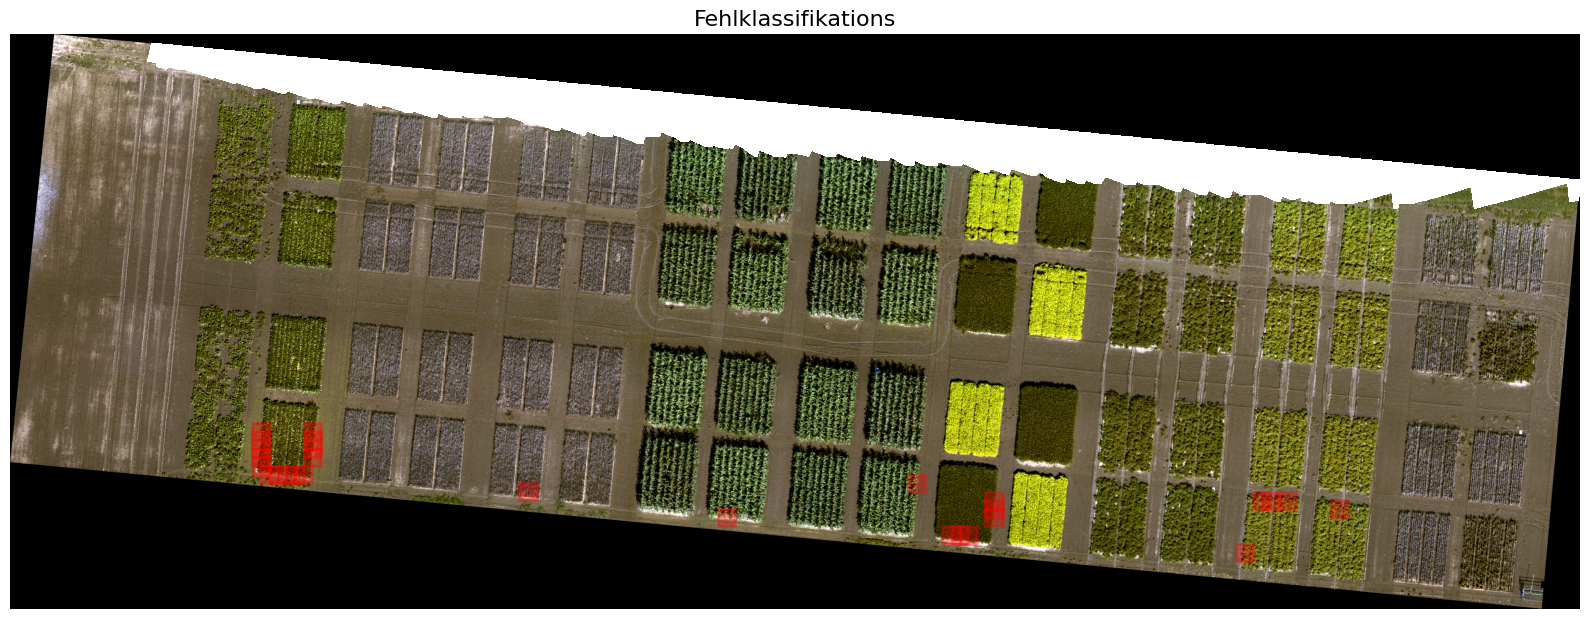

✅ Overlay-Bild gespeichert: output/fehlklassifikationen_qgisrgb_overlay.png


In [50]:
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pathlib import Path

# === Parameter ===
patch_size   = 64
ortho_path   = "data/raw/230811_reflectance_ortho.tif"
patch_dir    = "patches_npy/230811_reflectance_ortho/patch"
errors_csv   = "rf_test_errors.csv"
output_plot  = "output/fehlklassifikationen_qgisrgb_overlay.png"

# QGIS-MinMax für RGB
R_MIN, R_MAX = 0, 0.268403
G_MIN, G_MAX = 0, 0.188155
B_MIN, B_MAX = 0, 0.11795

with rasterio.open(ortho_path) as src:
    red   = src.read(7).astype(np.float32)
    green = src.read(4).astype(np.float32)
    blue  = src.read(2).astype(np.float32)
    ortho_transform = src.transform

def stretch(band, bmin, bmax):
    return np.clip((band - bmin) / (bmax - bmin), 0, 1)

r_stretched = stretch(red,   R_MIN, R_MAX)
g_stretched = stretch(green, G_MIN, G_MAX)
b_stretched = stretch(blue,  B_MIN, B_MAX)

rgb = np.stack([r_stretched, g_stretched, b_stretched], axis=-1)

# Fehlklassifikationen laden
df = pd.read_csv(errors_csv)
df["patch_id"] = df["sample_id"].str.extract(r"(\d+)_")[0].astype(int)
df["class"]    = df["sample_id"].str.extract(r"class(\d+)")[0].astype(int)

# Plot mit RGB
fig, ax = plt.subplots(figsize=(16, 8))
ax.imshow(rgb)

# Overlay: Fehlklassifizierte Patches als rote transparente Rechtecke
for _, row in df.iterrows():
    patch_id = int(row["patch_id"])
    cls      = int(row["class"])
    patch_path = Path(patch_dir) / f"{patch_id}_class{cls}.tif"
    if not patch_path.exists():
        print(f"⚠️ Patch fehlt: {patch_path}")
        continue

    with rasterio.open(patch_path) as patch_src:
        left, top = patch_src.transform * (0, 0)

    col, row_px = ~ortho_transform * (left, top)
    col, row_px = int(round(col)), int(round(row_px))

    rect = Rectangle((col, row_px), patch_size, patch_size,
                     edgecolor='red', facecolor='red', alpha=0.3, linewidth=2)
    ax.add_patch(rect)

plt.title("Fehlklassifikations", fontsize=16)
plt.axis("off")
plt.tight_layout()
Path("output").mkdir(exist_ok=True)
plt.savefig(output_plot, dpi=300)
plt.show()
print(f"✅ Overlay-Bild gespeichert: {output_plot}")


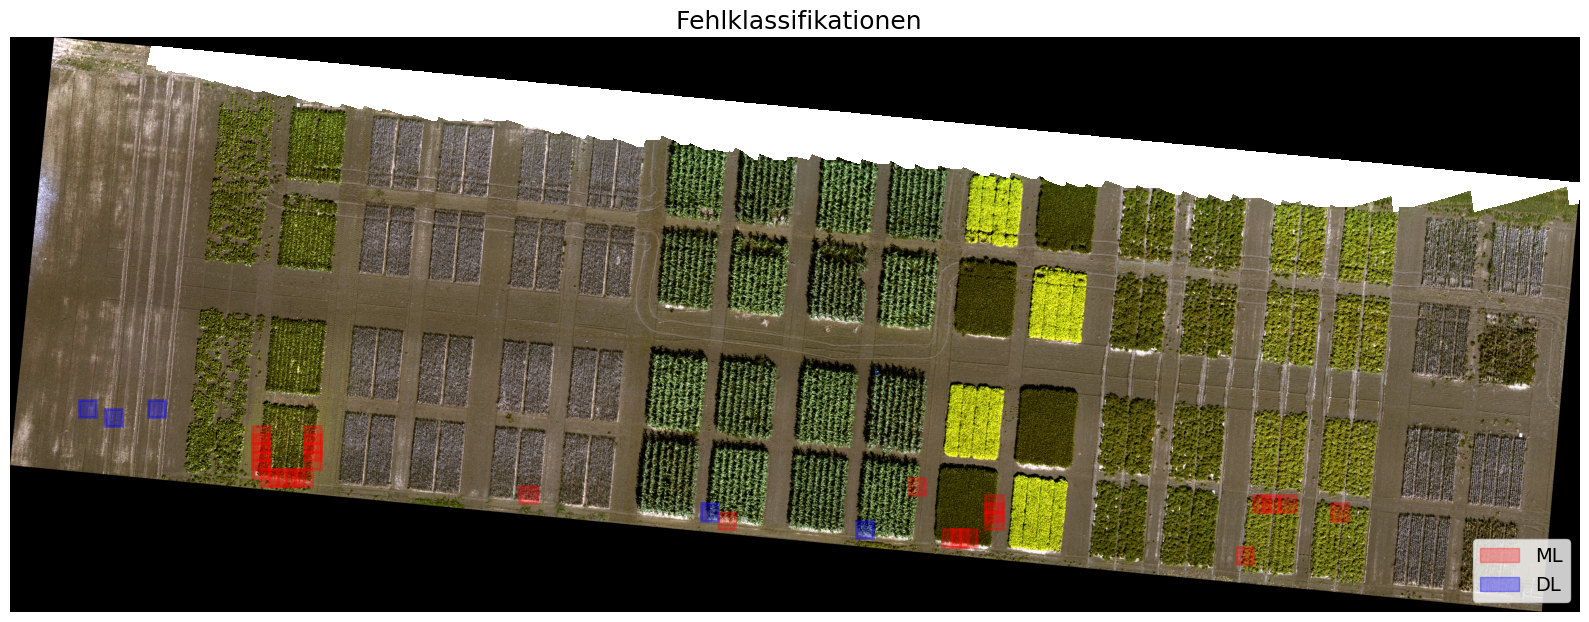

✅ Overlay-Bild mit Legende gespeichert: output/fehlklassifikationen_qgisrgb_overlay_legende.png


In [52]:
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from pathlib import Path

# === Parameter ===
patch_size   = 64
ortho_path   = "data/raw/230811_reflectance_ortho.tif"
patch_dir    = "patches_npy/230811_reflectance_ortho/patch"
errors_csv   = "rf_test_errors.csv"
output_plot  = "output/fehlklassifikationen_qgisrgb_overlay_legende.png"

# QGIS-MinMax für RGB
R_MIN, R_MAX = 0, 0.268403
G_MIN, G_MAX = 0, 0.188155
B_MIN, B_MAX = 0, 0.11795

with rasterio.open(ortho_path) as src:
    red   = src.read(7).astype(np.float32)
    green = src.read(4).astype(np.float32)
    blue  = src.read(2).astype(np.float32)
    ortho_transform = src.transform

def stretch(band, bmin, bmax):
    return np.clip((band - bmin) / (bmax - bmin), 0, 1)

r_stretched = stretch(red,   R_MIN, R_MAX)
g_stretched = stretch(green, G_MIN, G_MAX)
b_stretched = stretch(blue,  B_MIN, B_MAX)

rgb = np.stack([r_stretched, g_stretched, b_stretched], axis=-1)

# Fehlklassifikationen laden
df = pd.read_csv(errors_csv)
df["patch_id"] = df["sample_id"].str.extract(r"(\d+)_")[0].astype(int)
df["class"]    = df["sample_id"].str.extract(r"class(\d+)")[0].astype(int)

# Spezialpatches (IDs von dir)
special_patches = [4090, 4098, 4234, 5825, 6015]

# Plot mit RGB
fig, ax = plt.subplots(figsize=(16, 8))
ax.imshow(rgb)

# Overlay: Fehlklassifikationen als Rot
for _, row in df.iterrows():
    patch_id = int(row["patch_id"])
    cls      = int(row["class"])
    patch_path = Path(patch_dir) / f"{patch_id}_class{cls}.tif"
    if not patch_path.exists():
        continue
    with rasterio.open(patch_path) as patch_src:
        left, top = patch_src.transform * (0, 0)
    col, row_px = ~ortho_transform * (left, top)
    col, row_px = int(round(col)), int(round(row_px))
    rect = Rectangle((col, row_px), patch_size, patch_size,
                     edgecolor='red', facecolor='red', alpha=0.3, linewidth=2)
    ax.add_patch(rect)

# Overlay: Spezialpatches als Blau
for patch_id in special_patches:
    found = False
    for cls in [5, 6]:  # falls du weißt, welche Klasse passt, nimm nur die
        patch_path = Path(patch_dir) / f"{patch_id}_class{cls}.tif"
        if not patch_path.exists():
            continue
        with rasterio.open(patch_path) as patch_src:
            left, top = patch_src.transform * (0, 0)
        col, row_px = ~ortho_transform * (left, top)
        col, row_px = int(round(col)), int(round(row_px))
        rect = Rectangle((col, row_px), patch_size, patch_size,
                         edgecolor='blue', facecolor='blue', alpha=0.35, linewidth=2)
        ax.add_patch(rect)
        found = True
        break
    if not found:
        print(f"Spezialpatch {patch_id} nicht gefunden.")

# Legende manuell einfügen
handles = [
    Patch(facecolor='red', edgecolor='red', alpha=0.3, label='ML'),
    Patch(facecolor='blue', edgecolor='blue', alpha=0.35, label='DL')
]
ax.legend(handles=handles, loc='lower right', fontsize=14, frameon=True)

plt.title(" Fehlklassifikationen", fontsize=18)
plt.axis("off")
plt.tight_layout()
Path("output").mkdir(exist_ok=True)
plt.savefig(output_plot, dpi=300)
plt.show()
print(f"✅ Overlay-Bild mit Legende gespeichert: {output_plot}")


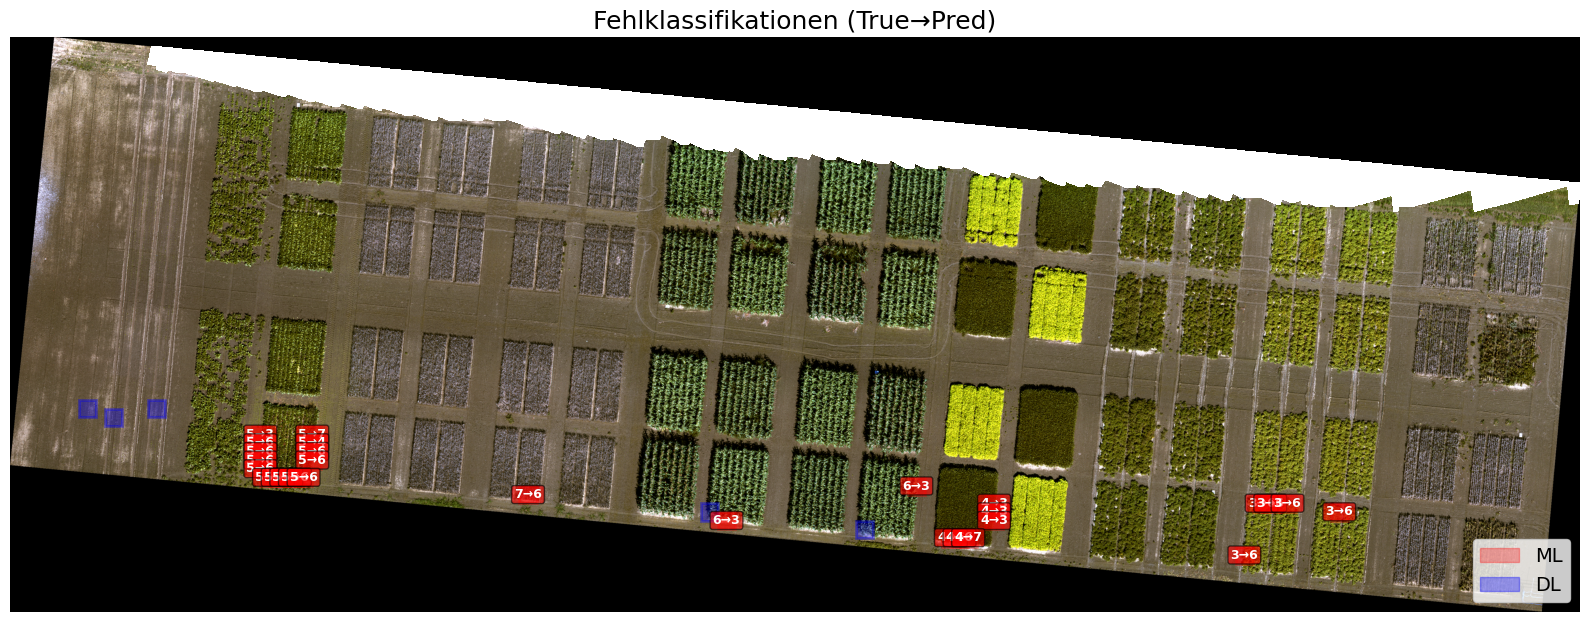

✅ Overlay-Bild mit Legende gespeichert: output/fehlklassifikationen_qgisrgb_overlay_legende.png


In [1]:
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from pathlib import Path

# === Parameter ===
patch_size   = 64
ortho_path   = "data/raw/230811_reflectance_ortho.tif"
patch_dir    = "patches_npy/230811_reflectance_ortho/patch"
errors_csv   = "rf_test_errors.csv"
output_plot  = "output/fehlklassifikationen_qgisrgb_overlay_legende.png"

# QGIS-MinMax für RGB
R_MIN, R_MAX = 0, 0.268403
G_MIN, G_MAX = 0, 0.188155
B_MIN, B_MAX = 0, 0.11795

with rasterio.open(ortho_path) as src:
    red   = src.read(7).astype(np.float32)
    green = src.read(4).astype(np.float32)
    blue  = src.read(2).astype(np.float32)
    ortho_transform = src.transform

def stretch(band, bmin, bmax):
    return np.clip((band - bmin) / (bmax - bmin), 0, 1)

r_stretched = stretch(red,   R_MIN, R_MAX)
g_stretched = stretch(green, G_MIN, G_MAX)
b_stretched = stretch(blue,  B_MIN, B_MAX)

rgb = np.stack([r_stretched, g_stretched, b_stretched], axis=-1)

# Fehlklassifikationen laden
df = pd.read_csv(errors_csv)
df["patch_id"] = df["sample_id"].str.extract(r"(\d+)_")[0].astype(int)
df["class"]    = df["sample_id"].str.extract(r"class(\d+)")[0].astype(int)

# Spezialpatches (IDs von dir)
special_patches = [4090, 4098, 4234, 5825, 6015]

# Plot mit RGB
fig, ax = plt.subplots(figsize=(16, 8))
ax.imshow(rgb)

# Overlay: Fehlklassifikationen als Rot mit Label
for _, row in df.iterrows():
    patch_id = int(row["patch_id"])
    cls      = int(row["class"])
    true_lbl = int(row["true_label"])
    pred_lbl = int(row["predicted_label"])
    patch_path = Path(patch_dir) / f"{patch_id}_class{cls}.tif"
    if not patch_path.exists():
        continue
    with rasterio.open(patch_path) as patch_src:
        left, top = patch_src.transform * (0, 0)
    col, row_px = ~ortho_transform * (left, top)
    col, row_px = int(round(col)), int(round(row_px))
    rect = Rectangle((col, row_px), patch_size, patch_size,
                     edgecolor='red', facecolor='red', alpha=0.3, linewidth=2)
    ax.add_patch(rect)
    # Beschriftung True→Pred
    ax.text(
        col + patch_size/2, row_px + 7,
        f"{true_lbl}→{pred_lbl}",
        color='white', fontsize=9, fontweight='bold',
        ha='center', va='top',
        bbox=dict(facecolor='red', alpha=0.6, boxstyle="round,pad=0.2")
    )

# Overlay: Spezialpatches als Blau
for patch_id in special_patches:
    found = False
    for cls in [5, 6]:  # falls du weißt, welche Klasse passt, nimm nur die
        patch_path = Path(patch_dir) / f"{patch_id}_class{cls}.tif"
        if not patch_path.exists():
            continue
        with rasterio.open(patch_path) as patch_src:
            left, top = patch_src.transform * (0, 0)
        col, row_px = ~ortho_transform * (left, top)
        col, row_px = int(round(col)), int(round(row_px))
        rect = Rectangle((col, row_px), patch_size, patch_size,
                         edgecolor='blue', facecolor='blue', alpha=0.35, linewidth=2)
        ax.add_patch(rect)
        found = True
        break
    if not found:
        print(f"Spezialpatch {patch_id} nicht gefunden.")

# Legende manuell einfügen
handles = [
    Patch(facecolor='red', edgecolor='red', alpha=0.3, label='ML'),
    Patch(facecolor='blue', edgecolor='blue', alpha=0.35, label='DL')
]
ax.legend(handles=handles, loc='lower right', fontsize=14, frameon=True)

plt.title("Fehlklassifikationen (True→Pred)", fontsize=18)
plt.axis("off")
plt.tight_layout()
Path("output").mkdir(exist_ok=True)
plt.savefig(output_plot, dpi=300)
plt.show()
print(f"✅ Overlay-Bild mit Legende gespeichert: {output_plot}")


==== RF-FeatureSelection Modell ====
=== Train (RF-FS) ===
              precision    recall  f1-score   support

      Potato       0.96      1.00      0.98       403
     Soybean       0.96      0.95      0.96       195
  Sugar Beet       0.99      0.98      0.98       405
  Sugar Corn       0.98      0.96      0.97       392
 Summerwheat       1.00      1.00      1.00       401

    accuracy                           0.98      1796
   macro avg       0.98      0.98      0.98      1796
weighted avg       0.98      0.98      0.98      1796

Accuracy: 0.9805122494432071


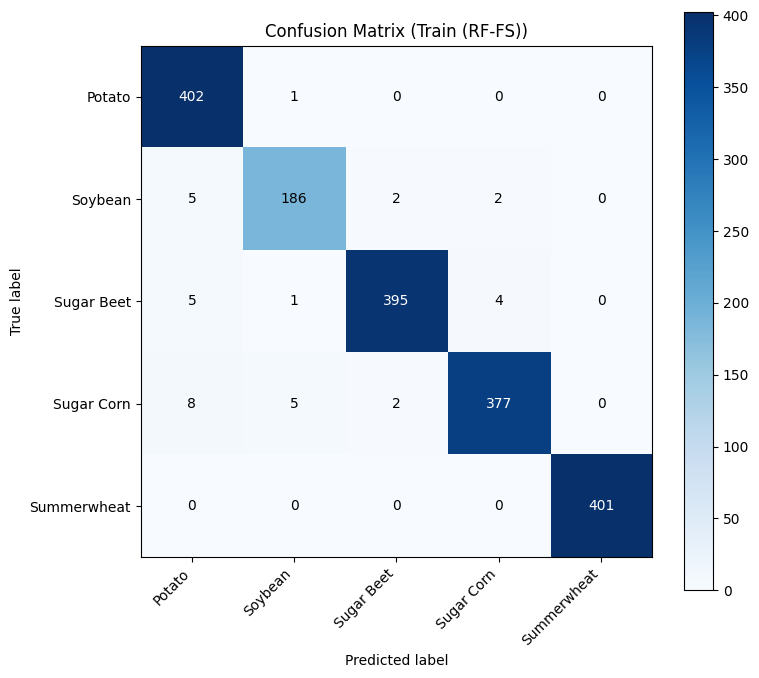


Confusion Matrix (Train (RF-FS)):
             Potato  Soybean  Sugar Beet  Sugar Corn  Summerwheat
Potato          402        1           0           0            0
Soybean           5      186           2           2            0
Sugar Beet        5        1         395           4            0
Sugar Corn        8        5           2         377            0
Summerwheat       0        0           0           0          401
=== Validation (RF-FS) ===
              precision    recall  f1-score   support

      Potato       0.95      1.00      0.97       198
     Soybean       0.97      0.99      0.98        99
  Sugar Beet       1.00      0.93      0.97       195
  Sugar Corn       0.99      0.99      0.99       197
 Summerwheat       1.00      1.00      1.00       200

    accuracy                           0.98       889
   macro avg       0.98      0.98      0.98       889
weighted avg       0.98      0.98      0.98       889

Accuracy: 0.983127109111361


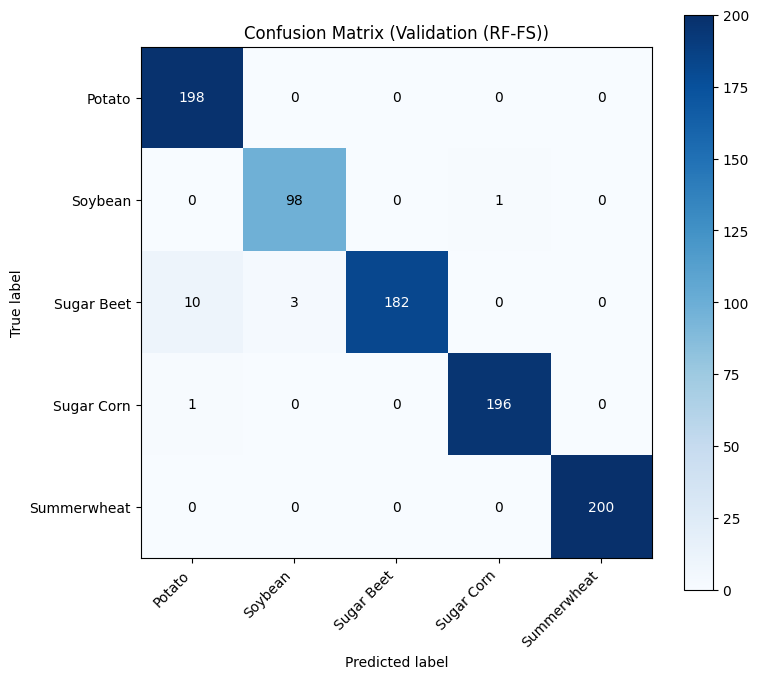


Confusion Matrix (Validation (RF-FS)):
             Potato  Soybean  Sugar Beet  Sugar Corn  Summerwheat
Potato          198        0           0           0            0
Soybean           0       98           0           1            0
Sugar Beet       10        3         182           0            0
Sugar Corn        1        0           0         196            0
Summerwheat       0        0           0           0          200
=== Test (RF-FS) ===
              precision    recall  f1-score   support

      Potato       0.81      1.00      0.90       198
     Soybean       0.81      0.70      0.75       100
  Sugar Beet       1.00      0.73      0.85       202
  Sugar Corn       0.85      0.95      0.90       197
 Summerwheat       1.00      1.00      1.00       195

    accuracy                           0.90       892
   macro avg       0.90      0.88      0.88       892
weighted avg       0.91      0.90      0.89       892

Accuracy: 0.8957399103139013


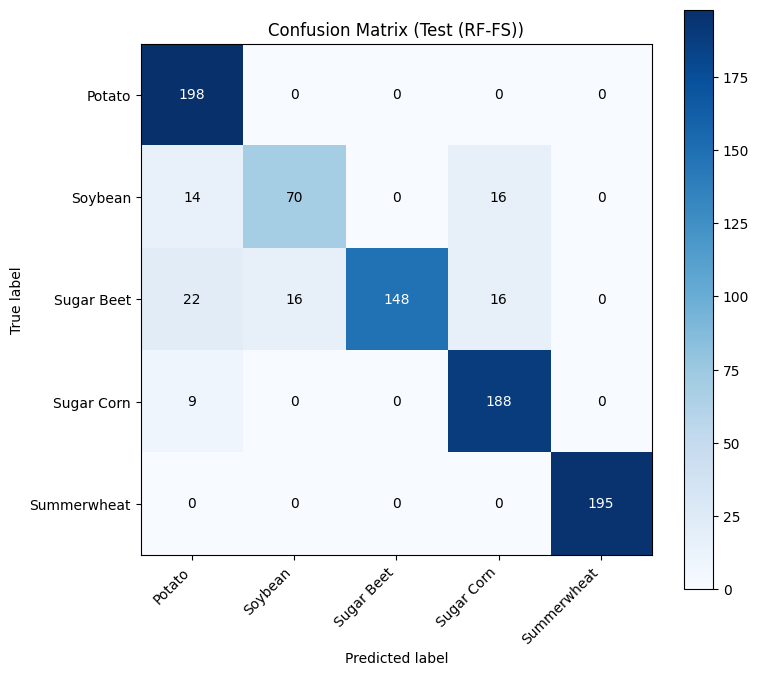


Confusion Matrix (Test (RF-FS)):
             Potato  Soybean  Sugar Beet  Sugar Corn  Summerwheat
Potato          198        0           0           0            0
Soybean          14       70           0          16            0
Sugar Beet       22       16         148          16            0
Sugar Corn        9        0           0         188            0
Summerwheat       0        0           0           0          195
==== PCA-Modell ====
=== Train (PCA) ===
              precision    recall  f1-score   support

      Potato       0.97      1.00      0.98       403
     Soybean       0.99      0.93      0.96       195
  Sugar Beet       1.00      0.99      0.99       405
  Sugar Corn       0.97      0.99      0.98       392
 Summerwheat       1.00      1.00      1.00       401

    accuracy                           0.99      1796
   macro avg       0.99      0.98      0.98      1796
weighted avg       0.99      0.99      0.99      1796

Accuracy: 0.9860801781737194


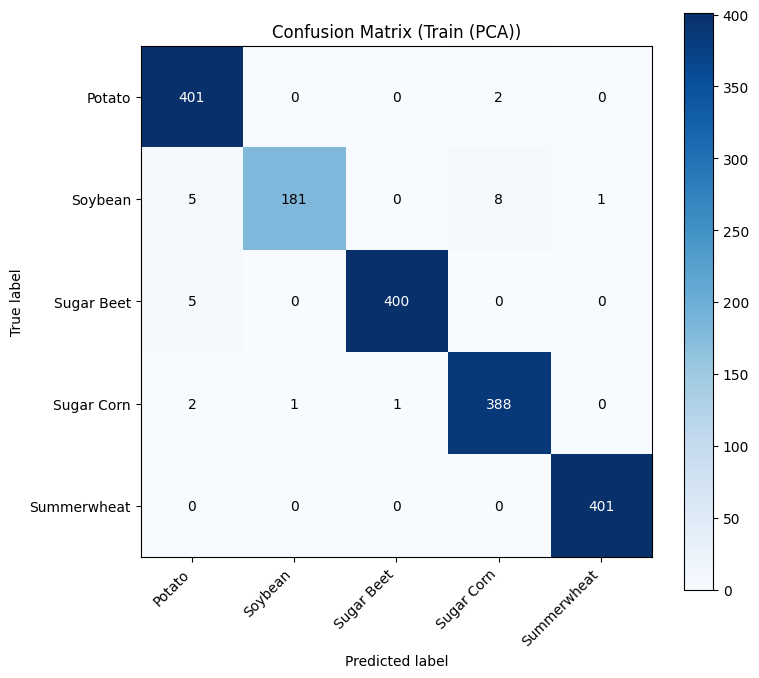


Confusion Matrix (Train (PCA)):
             Potato  Soybean  Sugar Beet  Sugar Corn  Summerwheat
Potato          401        0           0           2            0
Soybean           5      181           0           8            1
Sugar Beet        5        0         400           0            0
Sugar Corn        2        1           1         388            0
Summerwheat       0        0           0           0          401
=== Validation (PCA) ===
              precision    recall  f1-score   support

      Potato       0.97      0.96      0.97       198
     Soybean       0.99      0.92      0.95        99
  Sugar Beet       1.00      0.96      0.98       195
  Sugar Corn       0.92      1.00      0.96       197
 Summerwheat       1.00      1.00      1.00       200

    accuracy                           0.97       889
   macro avg       0.98      0.97      0.97       889
weighted avg       0.98      0.97      0.97       889

Accuracy: 0.9741282339707537


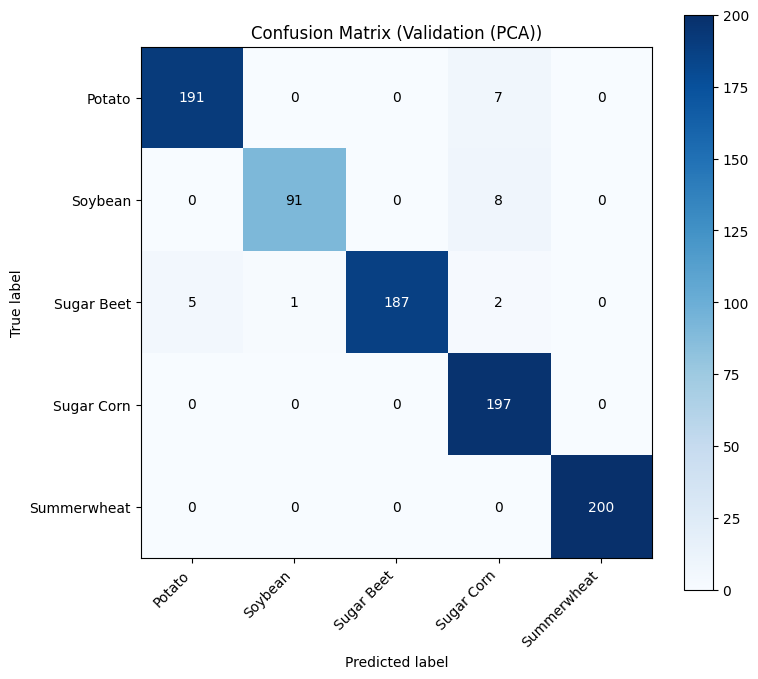


Confusion Matrix (Validation (PCA)):
             Potato  Soybean  Sugar Beet  Sugar Corn  Summerwheat
Potato          191        0           0           7            0
Soybean           0       91           0           8            0
Sugar Beet        5        1         187           2            0
Sugar Corn        0        0           0         197            0
Summerwheat       0        0           0           0          200
=== Test (PCA) ===
              precision    recall  f1-score   support

      Potato       0.97      0.97      0.97       198
     Soybean       0.99      0.94      0.96       100
  Sugar Beet       1.00      0.93      0.96       202
  Sugar Corn       0.91      0.99      0.95       197
 Summerwheat       0.99      0.99      0.99       195

    accuracy                           0.97       892
   macro avg       0.97      0.97      0.97       892
weighted avg       0.97      0.97      0.97       892

Accuracy: 0.968609865470852


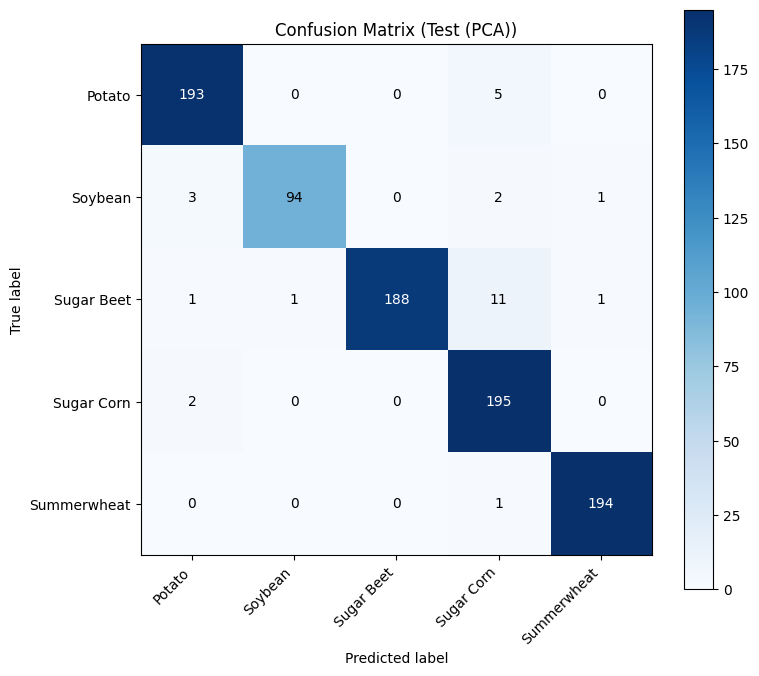


Confusion Matrix (Test (PCA)):
             Potato  Soybean  Sugar Beet  Sugar Corn  Summerwheat
Potato          193        0           0           5            0
Soybean           3       94           0           2            1
Sugar Beet        1        1         188          11            1
Sugar Corn        2        0           0         195            0
Summerwheat       0        0           0           1          194


In [11]:

# ==== 10. Ausgiebige Evaluation Train/Val/Test für beide Methoden ====
print("==== RF-FeatureSelection Modell ====")
full_evaluation(clf_fs, X_train_fs, y_train, "Train (RF-FS)")
full_evaluation(clf_fs, X_val_fs, y_val, "Validation (RF-FS)")
full_evaluation(clf_fs, X_test_fs, y_test, "Test (RF-FS)")

print("==== PCA-Modell ====")
full_evaluation(clf_pca, X_train_pca, y_train, "Train (PCA)")
full_evaluation(clf_pca, X_val_pca, y_val, "Validation (PCA)")
full_evaluation(clf_pca, X_test_pca, y_test, "Test (PCA)")


In [ ]:

# ==== 11. Modelle speichern ====
joblib.dump(clf_fs, "rf_fs_model.joblib")
joblib.dump(clf_pca, "rf_pca_model.joblib")
joblib.dump(pca, "pca_model.joblib")
joblib.dump(scaler, "scaler_model.joblib")
joblib.dump(imputer, "imputer_model.joblib")


In [ ]:
import matplotlib.pyplot as plt

# Replace these values with your own scores
macro_f1_train = 0.99
macro_f1_val   = 0.97
macro_f1_test  = 0.96

splits = ['Train', 'Validation', 'Test']
f1_scores = [macro_f1_train, macro_f1_val, macro_f1_test]

plt.figure(figsize=(5, 5))
bars = plt.bar(splits, f1_scores, color=['#4F8EF7', '#9D65C9', '#6CB49B'])
plt.ylim(0.8, 1.05)
plt.ylabel("F1 Score")
plt.title("F1 Score by Split – PCA Model")

for bar, value in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, value-0.05, f"{value:.2f}", 
             ha='center', va='bottom', color='white', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()


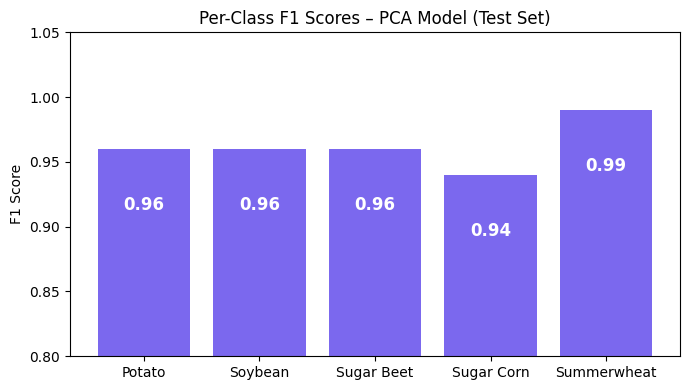

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Your decoded class labels (skipping indices if not used)
decoded_labels = [
    "None",                # class0
    "Mixture (faba)",      # class1
    "Mixture (wheat)",     # class2
    "Potato",              # class3
    "Soybean",             # class4
    "Sugar Beet",          # class5
    "Sugar Corn",          # class6
    "Summerwheat"          # class7
]

# Indices of your present classes (from your test report, e.g. classes = [3,4,5,6,7])
present_classes = [3,4,5,6,7]
present_labels = [decoded_labels[c] for c in present_classes]

# F1 scores from your report (order should match 'present_classes')
f1_scores = [0.96, 0.96, 0.96, 0.94, 0.99]

plt.figure(figsize=(7,4))
bars = plt.bar(present_labels, f1_scores, color='mediumslateblue')
plt.ylim(0.8, 1.05)
plt.ylabel("F1 Score")
plt.title("Per-Class F1 Scores – PCA Model (Test Set)")

# Annotate bars with values
for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()-0.05, f"{score:.2f}", ha='center', va='bottom', color='white', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
# use to search for ideal amount of feats

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFECV

# 1) Daten skalieren (falls nicht schon geschehen)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 2) Basis-Hyperparameter
rf_kws = {
    "n_estimators": 600,
    "max_depth": 10,
    "min_samples_split": 10,
    "min_samples_leaf": 15,
    "max_features": "log2",
    "bootstrap": True,
    "oob_score": True,
    "class_weight": None,
    "random_state": 42,
    "n_jobs": -1
}

# 3) Automatische Auswahl der optimalen Top-N Features
results = []
TOP_N_list = [10, 15, 20, 25]

for N in TOP_N_list:
    # RF zum Ermitteln der Feature-Importances
    rf_tmp = RandomForestClassifier(**rf_kws)
    rf_tmp.fit(X_train_scaled, y_train)
    importances = rf_tmp.feature_importances_
    # FIX: feat_names ist bereits eine Liste, kein DataFrame!
    feat_names_arr = np.array(feat_names)
    
    # Top-N Features auswählen
    top_idx   = np.argsort(importances)[::-1][:N]
    top_feats = feat_names_arr[top_idx]
    
    # Modell mit den Top-N Features trainieren
    rf_n = RandomForestClassifier(**rf_kws)
    rf_n.fit(X_train_scaled[:, top_idx], y_train)
    
    # Metriken erfassen
    oob     = rf_n.oob_score_
    acc_test = accuracy_score(y_test, rf_n.predict(X_test_scaled[:, top_idx]))
    gap      = oob - acc_test
    
    results.append({
        "TOP_N": N,
        "OOB_Score": oob,
        "Test_Acc": acc_test,
        "OOB-Test_Gap": gap
    })

df_results = pd.DataFrame(results).sort_values("OOB-Test_Gap")
print("=== Übersicht: Overfitting-Gap pro TOP_N ===")
display(df_results)

# 4) RFECV für automatische Feature-Auswahl
rf_ecv = RandomForestClassifier(**rf_kws)
rfecv = RFECV(
    estimator=rf_ecv,
    step=1,
    cv=5,
    scoring='f1_macro',
    min_features_to_select=5,
    n_jobs=-1
)
rfecv.fit(X_train_scaled, y_train)

print(f"\nOptimal number of features via RFECV: {rfecv.n_features_}")
# FIX: feat_names ist eine Liste, kein DataFrame!
selected = np.array(feat_names)[rfecv.support_]
print("Selected features:", selected.tolist())


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [300, 400, 500, 600],
    'max_depth': [8, 10, 12, 15],
    'min_samples_split': [2, 5, 8, 10],
    'min_samples_leaf': [5, 10, 15, 20],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', None]
}

search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, bootstrap=True, oob_score=True),
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)
search.fit(X_train_scaled, y_train)
print("Best Params:", search.best_params_)
print("Best CV Macro-F1:", search.best_score_)


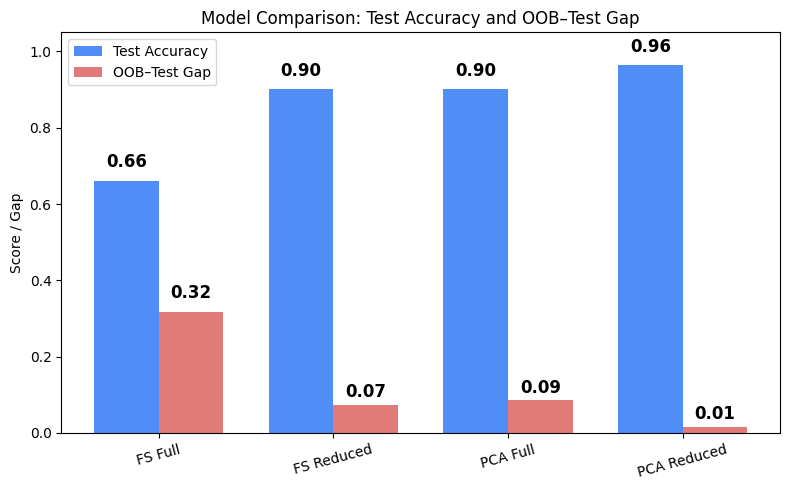

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Labels and data
labels = [
    'FS Full', 'FS Reduced',
    'PCA Full', 'PCA Reduced'
]
test_accs = [0.6614, 0.9002, 0.9002, 0.9641]
gaps      = [0.3169, 0.0736, 0.0853, 0.0147]

x = np.arange(len(labels))
width = 0.37

plt.figure(figsize=(8, 5))
bars1 = plt.bar(x - width/2, test_accs, width, label='Test Accuracy', color='#4F8EF7')
bars2 = plt.bar(x + width/2, gaps,      width, label='OOB–Test Gap', color='#E17B77')

plt.xticks(x, labels, rotation=15)
plt.ylim(0, 1.05)
plt.ylabel('Score / Gap')
plt.title('Model Comparison: Test Accuracy and OOB–Test Gap')

# Annotate bars
for bar in bars1 + bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.025 if height > 0.15 else height + 0.01, 
             f"{height:.2f}", ha='center', va='bottom', color='black', fontsize=12, fontweight='bold')

plt.legend()
plt.tight_layout()
plt.show()


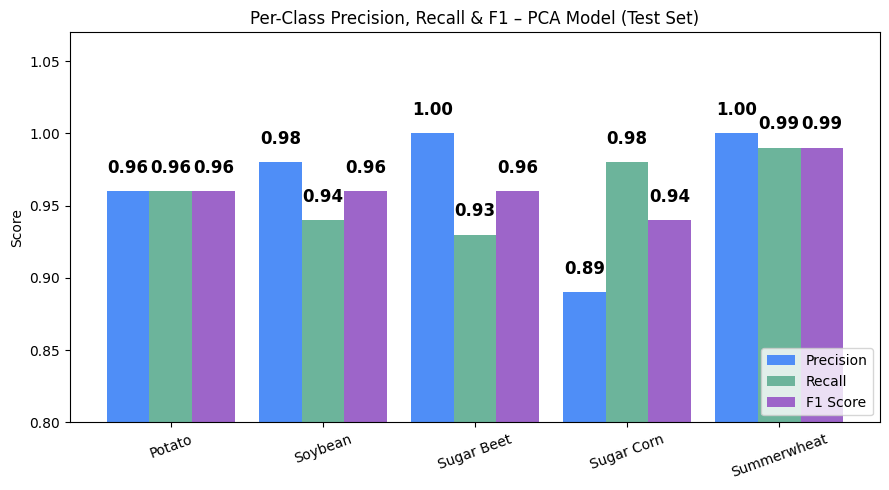

In [55]:
import numpy as np
import matplotlib.pyplot as plt

class_names = ["Potato", "Soybean", "Sugar Beet", "Sugar Corn", "Summerwheat"]
precision = [0.96, 0.98, 1.00, 0.89, 1.00]
recall    = [0.96, 0.94, 0.93, 0.98, 0.99]
f1        = [0.96, 0.96, 0.96, 0.94, 0.99]

x = np.arange(len(class_names))
width = 0.28  # thicker bars

plt.figure(figsize=(9, 5))
bars1 = plt.bar(x - width, precision, width, label='Precision', color='#4F8EF7')
bars2 = plt.bar(x,         recall,    width, label='Recall',    color='#6CB49B')
bars3 = plt.bar(x + width, f1,        width, label='F1 Score',  color='#9D65C9')

plt.xticks(x, class_names, rotation=20)
plt.ylim(0.8, 1.07)
plt.ylabel('Score')
plt.title('Per-Class Precision, Recall & F1 – PCA Model (Test Set)')
plt.legend(loc='lower right')

# Annotate bars with black numbers above each bar for clarity
for bar_group in [bars1, bars2, bars3]:
    for bar in bar_group:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}",
                 ha='center', va='bottom', color='black', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
# Ensure all required variables are defined
required = ["y_test", "clf_fs", "clf_pca", "X_test_fs", "X_test_pca", "top_idx", "top_feat_names", "pca"]
missing = [v for v in required if v not in globals()]
if missing:
    raise RuntimeError(f"Missing variables: {missing}. Please define before running plotting code.")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Prepare data
classes = np.unique(y_test)
y_pred_fs = clf_fs.predict(X_test_fs)
y_pred_pca = clf_pca.predict(X_test_pca)

# 1) Confusion Matrices (Test)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, (pred, title) in zip(axes, [(y_pred_fs, "RF + FS"), (y_pred_pca, "RF + PCA")]):
    cm = confusion_matrix(y_test, pred, labels=classes)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(f'Confusion Matrix (Test) - {title}')
    ax.set_xticks(range(len(classes))); ax.set_xticklabels(classes)
    ax.set_yticks(range(len(classes))); ax.set_yticklabels(classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center",
                    color="white" if cm[i, j] > cm.max()/2 else "black")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
fig.colorbar(im, ax=axes.tolist(), shrink=0.6)
plt.tight_layout()
plt.show()

# 2) Per-Class F1-Score Comparison (Test)
fs_f1 = f1_score(y_test, y_pred_fs, average=None, labels=classes)
pca_f1 = f1_score(y_test, y_pred_pca, average=None, labels=classes)

x = np.arange(len(classes))
width = 0.35
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, fs_f1, width, label='RF + FS')
plt.bar(x + width/2, pca_f1, width, label='RF + PCA')
plt.xticks(x, classes)
plt.ylabel('F1 Score')
plt.xlabel('Class Label')
plt.title('Per-Class F1 Score (Test)')
plt.legend()
plt.tight_layout()
plt.show()

# 3) Macro-Average ROC Curves (Test)
# Binarize labels
y_test_bin = label_binarize(y_test, classes=classes)
y_score_fs = clf_fs.predict_proba(X_test_fs)
y_score_pca = clf_pca.predict_proba(X_test_pca)

def compute_roc(y_test_bin, y_score):
    fpr = {}; tpr = {}; roc_auc = {}
    n_classes = y_test_bin.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # micro
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # macro
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    return fpr, tpr, roc_auc

fpr_fs, tpr_fs, roc_auc_fs = compute_roc(y_test_bin, y_score_fs)
fpr_pca, tpr_pca, roc_auc_pca = compute_roc(y_test_bin, y_score_pca)

plt.figure(figsize=(8, 6))
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.plot(fpr_fs["macro"], tpr_fs["macro"], label=f'RF+FS macro (AUC={roc_auc_fs["macro"]:.2f})', linestyle='-')
plt.plot(fpr_pca["macro"], tpr_pca["macro"], label=f'RF+PCA macro (AUC={roc_auc_pca["macro"]:.2f})', linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-Average ROC Curves (Test)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)  # Add this flag!
for ax, (pred, title) in zip(axes, [(y_pred_fs, "RF + FS"), (y_pred_pca, "RF + PCA")]):
    cm = confusion_matrix(y_test, pred, labels=classes)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(f'Confusion Matrix (Test) - {title}')
    ax.set_xticks(range(len(classes))); ax.set_xticklabels(classes)
    ax.set_yticks(range(len(classes))); ax.set_yticklabels(classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center",
                    color="white" if cm[i, j] > cm.max()/2 else "black")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Top 10 RF-Features ---
rf_top_n = 10
rf_top_idx = np.argsort(importances)[::-1][:rf_top_n]
rf_top_names = [feat_names[i] for i in rf_top_idx]
rf_top_importances = importances[rf_top_idx]

# --- Top 10 PCA-Features (by summed absolute loading across all components) ---
pca_abs_loadings = np.abs(pca.components_).sum(axis=0)
pca_top_idx = np.argsort(pca_abs_loadings)[::-1][:rf_top_n]
pca_top_names = [feat_names[i] for i in pca_top_idx]
pca_top_scores = pca_abs_loadings[pca_top_idx]

# --- Plot side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# RF
axes[0].barh(range(rf_top_n), rf_top_importances[::-1], color='royalblue')
axes[0].set_yticks(range(rf_top_n))
axes[0].set_yticklabels(rf_top_names[::-1])
axes[0].set_xlabel("RF Feature Importance")
axes[0].set_title("Top 10 RF-Features")

# PCA
axes[1].barh(range(rf_top_n), pca_top_scores[::-1], color='darkorange')
axes[1].set_yticks(range(rf_top_n))
axes[1].set_yticklabels(pca_top_names[::-1])
axes[1].set_xlabel("PCA Feature Score (|loading| sum)")
axes[1].set_title("Top 10 PCA-Features")

# Set same x-axis limits for direct comparison
max_lim = max(rf_top_importances.max(), pca_top_scores.max()) * 1.05
axes[0].set_xlim(0, max_lim)
axes[1].set_xlim(0, max_lim)

plt.tight_layout()
plt.show()

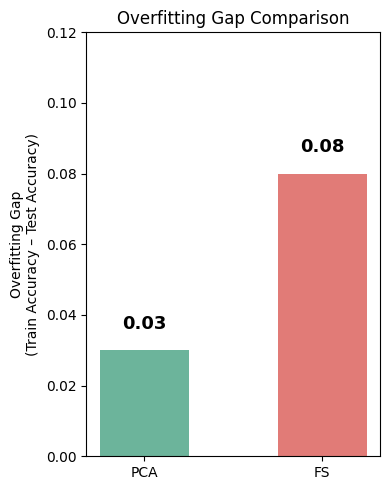

In [56]:
import matplotlib.pyplot as plt

# Data
models = ['PCA', 'FS']
gaps = [0.03, 0.08]

plt.figure(figsize=(4,5))
bars = plt.bar(models, gaps, color=['#6CB49B', '#E17B77'], width=0.5)
plt.ylim(0, 0.12)
plt.ylabel('Overfitting Gap\n(Train Accuracy – Test Accuracy)')
plt.title('Overfitting Gap Comparison')

# Annotate bars with values (in black above the bar)
for bar, value in zip(bars, gaps):
    plt.text(bar.get_x() + bar.get_width()/2, value + 0.005, f"{value:.2f}",
             ha='center', va='bottom', color='black', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()
